In [ ]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.mixture import BayesianGaussianMixture

from sklearn.decomposition import PCA

# Load and prepare data

df = pd.read_csv(r"./HR_Process_Dataset.csv")
df.info()
# Select relevant features for risk assessment

risk_features = ['Age', 'WorkLifeBalance', 'JobSatisfaction', 'HomeToWork', 'LastPromotion', 'HourlnWeek', 'OverTime', 'SalaryHikelastYear',
                       'MonthlyIncome', 'CurrentProfile', 'Involvement']

X = df[risk_features]

# Standardize features

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5180 entries, 0 to 5179
Data columns (total 33 columns):
 #   Column                            Non-Null Count  Dtype
---  ------                            --------------  -----
 0   EmployeeID                        5180 non-null   int64
 1   Attrition                         5180 non-null   int64
 2   Age                               5180 non-null   int64
 3   HomeToWork                        5180 non-null   int64
 4   HourlnWeek                        5180 non-null   int64
 5   Involvement                       5180 non-null   int64
 6   WorkLifeBalance                   5180 non-null   int64
 7   JobSatisfaction                   5180 non-null   int64
 8   ESOPs                             5180 non-null   int64
 9   NumCompaniesWorked                5180 non-null   int64
 10  OverTime                          5180 non-null   int64
 11  SalaryHikelastYear                5180 non-null   int64
 12  LastPromotion                     

In [20]:

## Bayesian Clustering with 3 components

bgmm = BayesianGaussianMixture(

    n_components=3,               # Force 3 clusters

    covariance_type='full',       # Each cluster has its own covariance

    weight_concentration_prior=0.01,  # Encourages more balanced clusters

    max_iter=1000,

    random_state=42,

    verbose=1

)

# Fit model

bgmm.fit(X_scaled)

# Get cluster assignments (0=Low, 1=Medium, 2=High risk)

clusters = bgmm.predict(X_scaled)

df['Risk_Cluster'] = clusters

## Analyze and label clusters based on risk profile

# Calculate cluster means

cluster_means = df.groupby('Risk_Cluster')[risk_features].mean()

# Identify risk levels (we'll order them from high to low risk)

risk_order = cluster_means['SalaryHikelastYear'].argsort()  # Lower salary hike = higher risk

risk_labels = {risk_order[0]: 'High Risk', 

               risk_order[1]: 'Medium Risk', 

               risk_order[2]: 'Low Risk'}

df['Risk_Label'] = df['Risk_Cluster'].map(risk_labels)


Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
Initialization converged: True


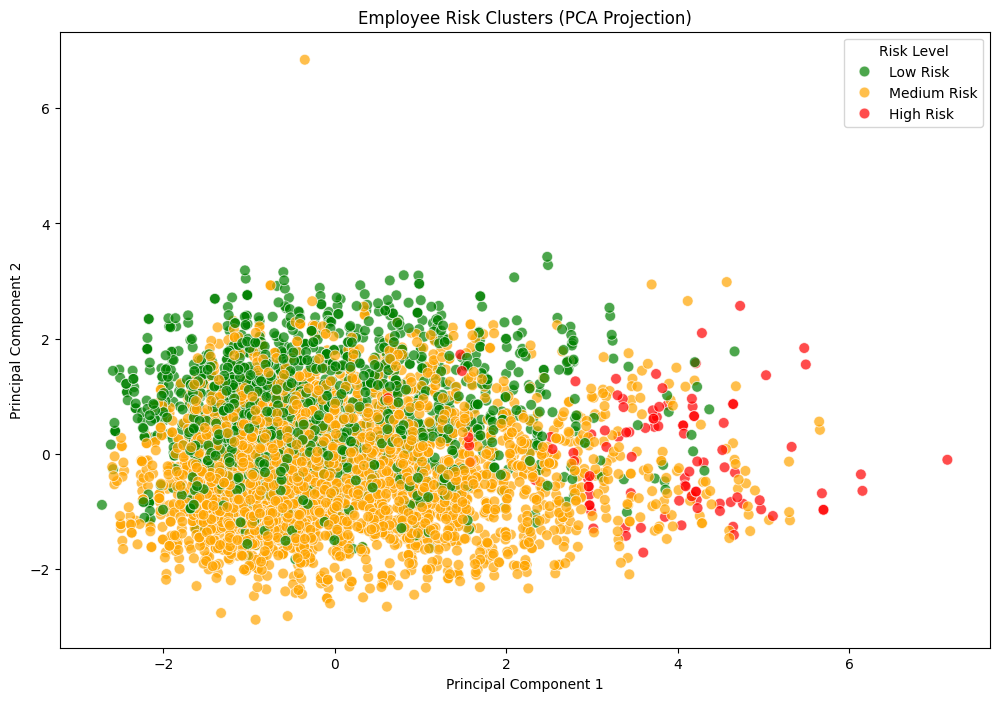

In [21]:

## Visualize clusters
# PCA for visualization

pca = PCA(n_components=2)

X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Risk_Label'], 

                palette={'High Risk':'red', 'Medium Risk':'orange', 'Low Risk':'green'}, 

                s=60, alpha=0.7)

plt.title('Employee Risk Clusters (PCA Projection)')

plt.xlabel('Principal Component 1')

plt.ylabel('Principal Component 2')

plt.legend(title='Risk Level')

plt.show()

## Cluster Profiles - Detailed Feature Analysis
cluster_profiles = df.groupby('Risk_Label')[risk_features].mean()

In [22]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(X_scaled, clusters)
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.1099


In [23]:
# Map PCA components to feature space
pca_components = pd.DataFrame(pca.components_, columns=risk_features, index=['PC1', 'PC2'])
print(pca_components.T.sort_values(by='PC1', ascending=False))  # Or PC2

                         PC1       PC2
MonthlyIncome       0.533019 -0.001539
CurrentProfile      0.511581  0.018008
LastPromotion       0.504701  0.002034
Age                 0.441777  0.058968
HomeToWork          0.014739  0.609558
JobSatisfaction    -0.001653  0.170781
WorkLifeBalance    -0.012855  0.201253
Involvement        -0.021211 -0.012736
SalaryHikelastYear -0.024704  0.316303
HourlnWeek         -0.028252  0.521901
OverTime           -0.045184  0.427050


In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Features and label
X_model = X_scaled
y_model = df['Risk_Label']  # Target

# Split
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=42)

# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   High Risk       0.82      1.00      0.90        27
    Low Risk       1.00      1.00      1.00       313
 Medium Risk       1.00      0.99      1.00       696

    accuracy                           0.99      1036
   macro avg       0.94      1.00      0.96      1036
weighted avg       1.00      0.99      0.99      1036

